# 1. Text preprocessing

In [1]:
with open('утро помещика.txt', 'r') as f:
  X = f.read()

X

'     Князю Нехлюдову было девятнадцать лет, когда он из 3-го курса университета приехал на летние ваканции в свою деревню и один пробыл в ней все лето. Осенью он неустановившейся ребяческой рукой написал к своей тетке, графине Белорецкой, которая, по его понятиям, была его лучший друг и самая гениальная женщина в мире, следующее переведенное здесь французское письмо: \n       "Милая тетушка. \n       Я принял решение, от которого должна зависеть участь всей моей жизни. Я выхожу из университета, чтоб посвятить себя жизни в деревне, потому что чувствую, что рожден для нее. Ради Бога, милая тетушка, не смейтесь надо мной. Вы скажете, что я молод; может быть, точно я еще ребенок, но это не мешает мне чувствовать мое призвание, желать делать добро и любить его. \n       Как я вам писал уже, я нашел дела в неописанном расстройстве. Желая их привести в порядок и вникнув в них, я открыл, что главное зло заключается в самом жалком, бедственном положении мужиков, и зло такое, которое можно испр

In [2]:
import nltk
import re

X = re.sub(r'\t+|\n+|\xa0—|\ufeff', ' ', X)
nltk.download('punkt')
X = nltk.tokenize.sent_tokenize(X)
print(len(X))
X

1630


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['     Князю Нехлюдову было девятнадцать лет, когда он из 3-го курса университета приехал на летние ваканции в свою деревню и один пробыл в ней все лето.',
 'Осенью он неустановившейся ребяческой рукой написал к своей тетке, графине Белорецкой, которая, по его понятиям, была его лучший друг и самая гениальная женщина в мире, следующее переведенное здесь французское письмо:         "Милая тетушка.',
 'Я принял решение, от которого должна зависеть участь всей моей жизни.',
 'Я выхожу из университета, чтоб посвятить себя жизни в деревне, потому что чувствую, что рожден для нее.',
 'Ради Бога, милая тетушка, не смейтесь надо мной.',
 'Вы скажете, что я молод; может быть, точно я еще ребенок, но это не мешает мне чувствовать мое призвание, желать делать добро и любить его.',
 'Как я вам писал уже, я нашел дела в неописанном расстройстве.',
 'Желая их привести в порядок и вникнув в них, я открыл, что главное зло заключается в самом жалком, бедственном положении мужиков, и зло такое, которое 

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
!python -m spacy download ru_core_news_md
import spacy
nlp = spacy.load('ru_core_news_md')
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tokenizer(sent):
  return [token.lemma_ for token in nlp(sent) if token.is_alpha]

stop_words = stopwords.words('russian')
vectorizer = CountVectorizer(binary=True,
                             stop_words = stop_words,
                             tokenizer = tokenizer)
data = vectorizer.fit_transform(X)
data = pd.DataFrame(data.todense(),
                    columns=vectorizer.get_feature_names_out())
data.info()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2022-11-13 20:54:40.432426: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.9 MB 69 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['весь', 'мочь', 'ничто', 'свой', 'хороший', 'это'] not in stop_words.
  % sorted(inconsistent)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Columns: 4602 entries, a to ёрзать
dtypes: int64(4602)
memory usage: 57.2 MB


# 2. Clustering tokens

In [4]:
from sklearn.cluster import FeatureAgglomeration

model = FeatureAgglomeration(n_clusters = None, distance_threshold = 0.1)
model.fit(data)
max_dist = max(model.distances_)

# максимальные расстояния между точками
max_dist

17.343692646955983

In [5]:
import numpy as np

dims = []
step = max_dist/50
for i in np.arange(step, max_dist, step):
  model = FeatureAgglomeration(n_clusters = None, distance_threshold = i)
  clusters = model.fit_transform(data)
  dims.append({'param': round(i, 3),
               'dim': clusters.shape[1]})
  
dims[:5]

[{'param': 0.347, 'dim': 2937},
 {'param': 0.694, 'dim': 2937},
 {'param': 1.041, 'dim': 2762},
 {'param': 1.387, 'dim': 2214},
 {'param': 1.734, 'dim': 1852}]

In [6]:
last = len(dims) - 1
dims[last]['diff'] = 0
for i, dim in enumerate(dims):
  if i == last:
    break
  dim['diff'] = dim['dim'] - dims[i+1]['dim']
dims[:5]

[{'param': 0.347, 'dim': 2937, 'diff': 0},
 {'param': 0.694, 'dim': 2937, 'diff': 175},
 {'param': 1.041, 'dim': 2762, 'diff': 548},
 {'param': 1.387, 'dim': 2214, 'diff': 362},
 {'param': 1.734, 'dim': 1852, 'diff': 345}]

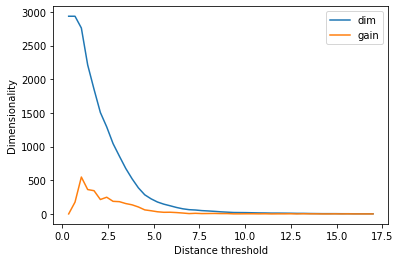

In [7]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in dims]
dim_list = [x['dim'] for x in dims]
diff_list = [x['diff'] for x in dims]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Dimensionality')
ax.set_xlabel('Distance threshold')
plt.plot(param_list, dim_list, label='dim')
plt.plot(param_list, diff_list, label='gain')
ax.legend()
plt.show()

In [8]:
dims_sorted = sorted(dims, key=lambda x: x['diff'], reverse=True)
threshold = dims_sorted[0]['param']

model = FeatureAgglomeration(n_clusters = None,
                             distance_threshold = threshold,
                             pooling_func = np.min)
data_clustered = model.fit_transform(data)
data_clustered = pd.DataFrame(data_clustered)
labels = model.labels_

data_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Columns: 2762 entries, 0 to 2761
dtypes: int64(2762)
memory usage: 34.3 MB


# 3. Relation extraction

In [9]:
from mlxtend.frequent_patterns import apriori

min_support = 2/len(data)
itemsets = apriori(data_clustered,
                   min_support = min_support,
                   max_len = 2)
itemsets

,support,itemsets
0,0.001227,(0)
1,0.001227,(1)
2,0.001227,(2)
3,0.001227,(4)
4,0.001227,(5)
...,...,...
7721,0.001227,"(2683, 2687)"
7722,0.001840,"(2695, 2687)"
7723,0.001227,"(2748, 2695)"
7724,0.001227,"(2698, 2703)"


In [10]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(itemsets, min_threshold = min_support)
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,0,629,0.001227,0.012270,0.001227,1.000000,81.500000,0.001212,inf
1,629,0,0.012270,0.001227,0.001227,0.100000,81.500000,0.001212,1.109748
2,0,1649,0.001227,0.004908,0.001227,1.000000,203.750000,0.001221,inf
3,1649,0,0.004908,0.001227,0.001227,0.250000,203.750000,0.001221,1.331697
4,0,1823,0.001227,0.029448,0.001227,1.000000,33.958333,0.001191,inf
...,...,...,...,...,...,...,...,...,...
11939,2695,2748,0.021472,0.001227,0.001227,0.057143,46.571429,0.001201,1.059305
11940,2698,2703,0.002454,0.050307,0.001227,0.500000,9.939024,0.001104,1.899387
11941,2703,2698,0.050307,0.002454,0.001227,0.024390,9.939024,0.001104,1.022485
11942,2698,2759,0.002454,0.015337,0.001227,0.500000,32.600000,0.001189,1.969325


In [11]:
incls = rules[rules['confidence'] == 1]
incls = incls[['antecedents', 'consequents']]
# если в предложении есть токен-antecedent, то есть и токен-consequent 100%

incls

,antecedents,consequents
0,0,629
2,0,1649
4,0,1823
6,5,1823
8,6,2591
...,...,...
11902,2617,2618
11928,2653,2687
11930,2653,2695
11933,2713,2664


# 4. Knowledge Graph

In [12]:
!pip install Cython
!pip install owlready2
from owlready2 import *
import types

onto = get_ontology('http://onto.owl')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
with onto:
  onto_sent = types.new_class('Sentence', (Thing,))
  types.new_class('hasText', (DataProperty, FunctionalProperty))
  for i, sent in enumerate(X):
    sent_inst = onto_sent(f'sentence_{i}')
    sent_inst.hasText = sent
    
onto.save('onto.owl')

In [14]:
with onto:
  onto_token = types.new_class('Token', (Thing,))
  for i, token in enumerate(data.columns):
    token_inst = onto_token(f'token_{i}')
    token_inst.label = token

onto.save('onto.owl')

In [15]:
with onto:
  hasToken = types.new_class('hasToken', (ObjectProperty,))
  for i, row in data.iterrows():
    sent_inst = onto[f'sentence_{i}']
    for j, token in enumerate(data.columns):
      if row[token] == 1:
        token_inst = onto[f'token_{j}']
        sent_inst.hasToken.append(token_inst)

onto.save('onto.owl')

In [16]:
with onto:
  onto_clust = types.new_class('Cluster', (Thing,))
  for label in set(labels):
    clust_cl = types.new_class(f'Cluster_{label}', (onto_clust,))

onto.save('onto.owl')

In [17]:
with onto:
  for i, label in enumerate(labels):
    clust_cl = onto[f'Cluster_{label}']
    token_inst = onto[f'token_{i}']
    clust_cl.equivalent_to.append(hasToken.value(token_inst))
onto.save('onto.owl')

In [18]:
with onto:
  for index, row in incls.iterrows():
    ant = row['antecedents']
    con = row['consequents']
    ant_cl = onto[f'Cluster_{ant}']
    con_cl = onto[f'Cluster_{con}']
    reverse = incls[(incls['antecedents'] == con) & (incls['consequents'] == ant)]
    if reverse.empty:
      # SubclassOf
      ant_cl.is_a.append(con_cl)
    else:
      ant_cl.equivalent_to.append(con_cl)
      
onto.save('onto.owl')

In [19]:
# onto = get_ontology("onto.owl").load()

In [20]:
with onto:
  sync_reasoner_pellet()

onto.save('onto_reasoned.owl', format='ntriples')

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-log4j12-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-runtime-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/log4j-1.2.16.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/xml-apis-1.4.01.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jgrapht-jdk1.5.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/commons-codec-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/pellet-2.3.1.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/aterm-java-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/httpcore-4.2.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-arq-2.10.0.jar:/usr/local/lib/python3.7/dist-packa